# Extended Data Fig. 10
- To find putative angular head velocity cells, we recorded activity widely from the hindbrain
- Fish first experienced short pulses of rotational optic flow.
    - This part of data is used to find rotationally direction selective (DS) visual cells.
- Next, fish experienced sustained sideways translational optic flow.
    - We then calculated the bout-triggered activity changes of the visually DS cells.
- AHV cells tuned to CW yaw rotation should be activated by left turns (and vice versa) 

In [1]:
# Load packages
from utility import *
from pathlib import Path
import numpy as np
import flammkuchen as fl
from bouter import EmbeddedExperiment
from matplotlib import  pyplot as plt
from scipy.stats import binned_statistic
import colorcet as cc
import json

C:\Users\ryosuke\miniconda3\envs\hd_pub\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ryosuke\miniconda3\envs\hd_pub\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\ryosuke\miniconda3\envs\hd_pub\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# configure matplotlib
config_rcparams()

In [3]:
# Parameters
# For sensory/motor triggered responses in the probe
probe_t_pre = 3
probe_t_post = 10

# For calculating motor triggered response
bias_thresh = 0.2 # in radian

# For selecting reliable, direction selective cells
corr_thresh = 0.4
z_thresh = 2.0

fr = 5.0 # frame rate
min_n_bout = 3 # bout number cutoff

## Additional utility functions

In [4]:
def cut_triggered_snip(data, t, triggers, snip_ind):
    snips = []
    for this_t in triggers:
        trigger_ind = np.argmax(t > this_t)
        try:
            snips.append(data[:, trigger_ind + snip_ind])
        except:
            print('too close to the end of experiment')
    if snips:
        return np.dstack(snips)
    else:
        return np.zeros((data.shape[0],len(snip_ind),0))

def med_corr(data):
    N = data.shape[0]
    return np.median(np.corrcoef(data)[np.triu(np.ones((N,N)),1)==1])
    
def mean_corr(data):
    N = data.shape[0]
    return np.mean(np.corrcoef(data)[np.triu(np.ones((N,N)),1)==1])

# Analysis
## Load data
- Recordings are mapped to local Z stack
- The local Z stacks are either mapped to caudal or anterior reference brain
- Anterior reference is further mapped onto (or rather, stitched to) the caudal reference
- Show everything in the same (combined, caudal-based) coordinate

In [5]:
# load combined reference stack
combined_ref_path = Path(r'../data/ed10/ref/combined_ref.h5')
temp = fl.load(combined_ref_path)
ref_stack = temp['combined_stack']
ref_stack_av = temp['combined_averaged_stack']
mat_a_to_comb = temp['mat_anterior_ref_to_combined']

In [32]:
# get the path to individual recordings
base = Path('../data/ed10')

# search directly for the mapped h5 file
files = list(base.rglob('data_mapped_*.h5'))
print('Found {} recordings'.format(len(files)))

Found 58 recordings


In [60]:
data = []
for file in files:
    plane_path = file.parent
    fish_path = file.parent.parent
    fish_name = file.parent.parent.name
    
    ###############
    ### Anatomy ###
    ###############
    
    # load ROI coordinate mapped to local Z stack, and get the zstack used to map
    orig_coords = fl.load(file)['orig_coords'] # use this to remove flyback ROIs
    coords = fl.load(file)['mapped_coords']
    zname = fl.load(file)['zstack_path'].name # Z stack name
    
    # find the zstack mapped to the common reference
    mapped_zpath = list((fish_path / 'zstack').glob(zname[:-3]+'_mapped*'))[0]
    
    # load affine transformation matrix
    # note, this transforms dots in the ref coordinates into individual z stack coordinates
    # (because that is how you morph image by resampling)
    # So I have to do the inverse transform to get the position of ROI in the ref coordinates
    mat_ref_to_z = fl.load(mapped_zpath)['mat']
    
    # separate translation vector and projection matrix
    A = mat_ref_to_z.T[:3, :]
    b = mat_ref_to_z.T[3, :]
    
    # apply inverse transformation to the ROI coodinates, bringing them in the anterior or caudal coordinate
    mapped_coords = (coords - b[None, :]) @ np.linalg.inv(A)
    
    # figure out which ref we are talking about
    
    if 'anterior' in mapped_zpath.name:
        mapped_coords = np.pad(mapped_coords, ((0,0), (0,1)), mode="constant", constant_values=1) @ mat_a_to_comb.T
    
    ################
    ### Function ###
    ################
    
    # Load imaging data and corresponding time stamps
    traces = fl.load(file)['traces']
    t_i = fl.load(plane_path / "time.h5")['t']
    
    # Load stimulus data
    exp = EmbeddedExperiment(plane_path / 'behavior')
    slog = exp['stimulus']['log']
    t_s = exp.stimulus_log['t'].to_numpy()
    
    # load behavior data (detect bouts)
    bouts = exp.get_bouts()
    bsum = exp.get_bout_properties()
    t_bout = bsum.t_start.to_numpy()
    bias = bsum.bias.to_numpy()
    t_b = exp.behavior_log['t'].to_numpy()
    tail_sum = exp.behavior_log['tail_sum']

    # Find when probe was presented
    p_name = list(exp['stimulus']['protocol'].keys())[0]
    v_name = list(exp['stimulus']['protocol'][p_name].keys())[0]
    probe_rep = exp['stimulus']['protocol'][p_name][v_name]['probe_rep']
    probe_dur = exp['stimulus']['protocol'][p_name][v_name]['probe_duration']
    probe_epoch_inds = [np.arange(probe_rep)*8+(2*i+1) for i in range(4)]
    probe_start_t = [[slog[i]['t_start'] for i in pei] for pei in probe_epoch_inds] 
    snip_ind = np.arange(-int(probe_t_pre*fr), int(probe_t_post*fr))
    snip_t = snip_ind.astype(float)/fr

    # cut out neural trace snippets
    probe_snips = np.asarray([cut_triggered_snip(traces, t_i, trig, snip_ind) for trig in probe_start_t]) # {type, ROI, time, rep}
    probe_corr = np.empty([4, probe_snips.shape[1]])

    # calculate correlation
    for r in range(probe_snips.shape[1]):
        for i in range(4):
            probe_corr[i, r] = mean_corr(probe_snips[i, r, :, :])

    max_corr = np.max(probe_corr, axis=0)
    correlated = np.any(probe_corr>corr_thresh, axis=0)
    
    # Convert probe resposne into dF/F
    f0 = np.mean(probe_snips[:, :, (snip_t<0), :], axis=2)
    df_f = (probe_snips - f0[:,:,None,:]) / f0[:,:,None,:]
    
    # calculate direction selectivity for rotational stimulus
    time_mean = np.mean(df_f[:, :, (snip_t>0)*(snip_t<probe_dur), :], axis=2)
    rep_mean = np.mean(time_mean, axis=2)
    rep_var = np.var(time_mean, axis=2)

    # directional z score, for both rotational/translational (R motion in front = positive)
    dir_z = (rep_mean[(0,3), :]-rep_mean[(2,1), :]) / np.sqrt((rep_var[(0,3), :]+rep_var[(2,1), :])/probe_rep)

    # Are ROIs DS in rotational dimension?
    rot_ds = np.abs(dir_z[0,:]) > z_thresh
    
    # remove flyback ROIs
    not_fb = orig_coords[:, 1] < 600 * 24/25 
    
    good_roi = correlated * rot_ds * not_fb
    print(plane_path.name, 'Found {}/{} good ROIs'.format(np.sum(good_roi), len(good_roi)))
    
    # calculate motor triggered response & convert them to dF/F & average over bouts
    pos_bout_t = [this_t for this_bias, this_t in zip(bias, t_bout) if (this_t>slog[-2]['t_start']) and (this_bias > bias_thresh)]
    neg_bout_t = [this_t for this_bias, this_t in zip(bias, t_bout) if (this_t>slog[-2]['t_start']) and (this_bias < -bias_thresh)]

    if (len(pos_bout_t)<min_n_bout or len(neg_bout_t)<min_n_bout):
        print('too few bouts, ignoring this plane')
        continue
    
    pb_snips = cut_triggered_snip(traces, t_i, pos_bout_t, snip_ind)
    nb_snips = cut_triggered_snip(traces, t_i, neg_bout_t, snip_ind)

    pb_f0 = np.mean(pb_snips[:, (snip_t<0), :], axis=1)
    nb_f0 = np.mean(nb_snips[:, (snip_t<0), :], axis=1)

    pb_df_f = (pb_snips - pb_f0[:,None,:]) / pb_f0[:,None,:]
    nb_df_f = (nb_snips - nb_f0[:,None,:]) / nb_f0[:,None,:]
    bout_resp = np.dstack((np.mean(pb_df_f, axis=2), np.mean(nb_df_f, axis=2)))
    
    ## Register everything (with selection)
    D = {
        'fish_name': fish_name,
        'file_path': file,
        'coords': mapped_coords[good_roi, :],
        'probe_resp': np.mean(df_f[:, good_roi, :, :], axis=3),
        'probe_z': dir_z[:, good_roi],
        'bout_resp': bout_resp[good_roi, :, :],
        'vel_params' : (exp['stimulus']['log'][1]['ang_vel'], exp['stimulus']['log'][3]['vel'], exp['stimulus']['log'][3]['phi'])
    }
    data.append(D)

20250318_f0_raphe_dorsal_end_0_postr4 Found 33/385 good ROIs
20250318_f0_raphe_dorsal_end_10_postr4 Found 16/413 good ROIs
20250318_f0_raphe_dorsal_end_20_postr4_copy Found 16/426 good ROIs
too close to the end of experiment
too close to the end of experiment
20250318_f0_raphe_dorsal_end_30_postr4_copy_copy Found 25/423 good ROIs
too close to the end of experiment
20250318_f0_raphe_dorsal_end_40_postr4 Found 60/427 good ROIs
20250318_f1_raphe_upper_lim_plus0 Found 32/359 good ROIs
too close to the end of experiment
20250318_f1_raphe_upper_lim_plus10 Found 8/404 good ROIs
20250318_f1_raphe_upper_lim_plus20 Found 15/410 good ROIs
too close to the end of experiment
20250318_f1_raphe_upper_lim_plus_30 Found 18/405 good ROIs
20250318_f2_raphe_upper_lim_minus_15 Found 16/348 good ROIs
20250318_f2_raphe_upper_lim_minus_5 Found 7/353 good ROIs
20250318_f2_raphe_upper_lim_plus_15 Found 13/381 good ROIs
too close to the end of experiment
20250318_f2_raphe_upper_lim_plus_5 Found 8/374 good ROIs
t

### Concatenate all ROI data across planes
- But also track which ROI came from which fish

In [61]:
fish_name_list = [D['fish_name'] for D in data]
unique_fish_names = np.unique(fish_name_list)
fish_id = [np.where(unique_fish_names==fn)[0][0] for fn in fish_name_list]
print('{} recs from {} fish'.format(len(data), max(fish_id)+1))

49 recs from 21 fish


In [62]:
all_coords = np.vstack([D['coords'] for D in data])
all_br = np.vstack([D['bout_resp'] for D in data])
all_pz = np.vstack([D['probe_z'].T for D in data])
all_pr = np.dstack((np.vstack([D['probe_resp'][0] for D in data]),
                     np.vstack([D['probe_resp'][2] for D in data])))
by_roi_fish_id = np.hstack([(fid,)*D['coords'].shape[0] for fid, D in zip(fish_id, data)])

# time average
all_mbr = np.mean(all_br[:, (snip_t>0)*(snip_t<3), :], axis=1)
all_dbr = all_mbr[:, 0] - all_mbr[:, 1]
vm_prod = all_pz[:,0]*all_dbr

In [63]:
# deal with image rotation
ref_rotated = np.rot90(np.flipud(ref_stack_av[:, ::-1, :660]), axes=(1,2))
new_coords = np.vstack((ref_rotated.shape[0]-all_coords[:, 0], 660-all_coords[:,2], 600-all_coords[:,1])).T

h_mean = np.mean(ref_rotated, axis=0)
s_mean = np.mean(ref_rotated, axis=2).T

# scale parameters
magnification = 3.0
xy_step = 500/3 / ref_stack_av.shape[1]
z_step = 1.0 # um

## Extended Data Fig. 10fgh (Individual ROI visualization)
- Visual and motor response
- product of the two
- show on horizontal and saggital projection

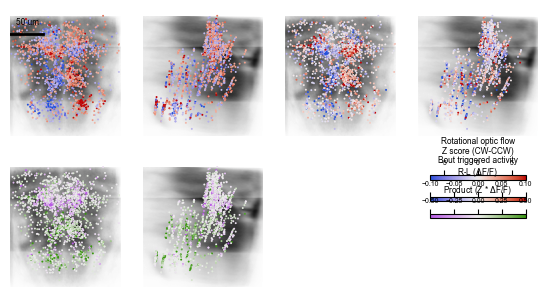

In [65]:
# to get a consistent scale across panels...
zy_ratio = (ref_rotated.shape[0]*z_step) / (ref_rotated.shape[1]*xy_step)
xy_ratio = ref_rotated.shape[2] / ref_rotated.shape[1]

unit_height = 1.8
total_width = unit_height * 2 * (zy_ratio+xy_ratio)
total_height = unit_height * 2

fig, ax = plt.subplots(2, 4, figsize=(total_width, total_height), width_ratios=(xy_ratio, zy_ratio,)*2)

# show mean projection image (probably delete for the final figure for visibility?)
for i in range(3):
    ax[i//2, (2*i)%4].imshow(h_mean, cmap=cc.cm.CET_L1_r, aspect='auto')
    ax[i//2, (2*i+1)%4].imshow(s_mean, cmap=cc.cm.CET_L1_r, aspect='auto')
ax[0,0].plot((0,50/xy_step), (100,100), 'k-', lw=2)
ax[0,0].text(30, 50, '50 um')

# scatter plot cells (horizontal)
s0 = ax[0,0].scatter(new_coords[:,2], new_coords[:,1], c=all_pz[:,0], vmin=-7, vmax=7, cmap=cc.cm.CET_D1, s=2, lw=0)
s1 = ax[0,2].scatter(new_coords[:,2], new_coords[:,1], c=all_dbr, vmin=-0.1, vmax=0.1, cmap=cc.cm.CET_D1, s=2, lw=0)
s2 = ax[1,0].scatter(new_coords[:,2], new_coords[:,1], c=vm_prod, vmin=-0.5, vmax=0.5, cmap=cc.cm.CET_D2_r, s=2, lw=0)
# sagittal  
ax[0,1].scatter(new_coords[:,0], new_coords[:,1], c=all_pz[:,0], vmin=-7, vmax=7, cmap=cc.cm.CET_D1, s=2, lw=0)
ax[0,3].scatter(new_coords[:,0], new_coords[:,1], c=all_dbr, vmin=-0.1, vmax=0.1, cmap=cc.cm.CET_D1, s=2, lw=0)
ax[1,1].scatter(new_coords[:,0], new_coords[:,1], c=vm_prod, vmin=-0.5, vmax=0.5, cmap=cc.cm.CET_D2_r, s=2, lw=0)

cb0 = plt.colorbar(s0, ax=ax[-1,-1], location='top', shrink=0.8)
cb1 = plt.colorbar(s1, ax=ax[-1,-1], location='top', shrink=0.8)
cb2 = plt.colorbar(s2, ax=ax[-1,-1], location='top', shrink=0.8)

cb0.set_label('Rotational optic flow\nZ score (CW-CCW)')
cb1.set_label('Bout triggered activity\nR-L ($\Delta$F/F)')
cb2.set_label('Product (Z * $\Delta$F/F)')
    
for axx in ax:
    for axxx in axx:
        toggle_spines(axxx,0,0,0,0)

plt.savefig('../svg/ed10_fgh.svg')        
plt.show()

## Extended Data Fig. 10i (Binned trace of visuo-motor product over Y, per each fish)

In [66]:
# do the binning
binned_vm_prod = []
y_bin_edge = np.linspace(0,660,7)
y_bin_center = (y_bin_edge[1:] + y_bin_edge[:-1])/2
for fid in np.unique(fish_id):
    this_fish = by_roi_fish_id==fid
    binned_vm_prod.append(binned_statistic(new_coords[this_fish,1], vm_prod[this_fish], bins=y_bin_edge)[0])
binned_vm_prod = np.vstack(binned_vm_prod)

In [67]:
# running stats... 
prod_p = [wilcoxon(y[np.isnan(y)==0])[1] for y in binned_vm_prod.T]

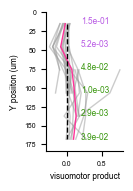

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(1, unit_height))
ax.plot(binned_vm_prod.T, y_bin_center*xy_step, color=color_getter(1), alpha=0.5)
ax.plot(np.nanmean(binned_vm_prod, axis=0), y_bin_center*xy_step, color=color_getter(0))
ax.plot(y_bin_center*0, y_bin_center*xy_step, 'k--')

for i in range(len(y_bin_center)):
    temp = np.nanmean(binned_vm_prod, axis=0)[i]<0
    ax.text(0.2, y_bin_center[i]*xy_step, '{:0.1e}'.format(prod_p[i]), color=cc.cm.CET_D2(temp*255))



ax.set_ylim(660*xy_step, 0)

ax.set_xlabel('visuomotor product')
ax.set_ylabel('Y posiiton (um)')
toggle_spines(ax, 0, 1, 0, 1)

plt.savefig('../svg/ed10_i.svg')
plt.show()

In [69]:
print('sample size for each bin:')
print(np.sum(np.isnan(binned_vm_prod)==0, axis=0))

sample size for each bin:
[13 16 20 18 11  8]


## Extended Data Fig. 10j (Mean time traces of r2/3 cells)

In [70]:
# do the averaging
mean_resp = []
is_rh23 = (new_coords[:,1] > y_bin_edge[1]) * (new_coords[:,1] < y_bin_edge[2])
for fid in np.unique(fish_id):
    this_fish_cw_roi =  (all_pz[:, 0]>0) * (by_roi_fish_id==fid) * is_rh23
    this_fish_ccw_roi = (all_pz[:, 0]<0) * (by_roi_fish_id==fid) * is_rh23
    
    mean_resp.append(
    (np.mean(all_pr[this_fish_cw_roi, :, :], axis=0),
     np.mean(all_pr[this_fish_ccw_roi, :, :], axis=0),
     np.mean(all_br[this_fish_cw_roi, :, :], axis=0),
     np.mean(all_br[this_fish_ccw_roi, :, :], axis=0)))
mean_resp = np.asarray(mean_resp) 

C:\Users\ryosuke\miniconda3\envs\hd_pub\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ryosuke\miniconda3\envs\hd_pub\lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [71]:
has_cw_rh23_cells = np.isnan(mean_resp[:, 0, 0, 0])==0
has_ccw_rh23_cells = np.isnan(mean_resp[:, 0, 0, 1])==0
print('sample size for each direction:')
print(np.sum(has_cw_rh23_cells), np.sum(has_ccw_rh23_cells))

sample size for each direction:
15 15


In [72]:
# average over animals & SEM
mean_mean_resp = np.nanmean(mean_resp, axis=0) # (cw probe, ccw probe, r turn, l turn) x time x cell type
sem_mean_resp = np.nanstd(mean_resp, axis=0) / np.sqrt((np.sum(has_cw_rh23_cells),np.sum(has_ccw_rh23_cells)))[..., :]
t_x = np.arange(mean_resp.shape[2]) / fr - probe_t_pre

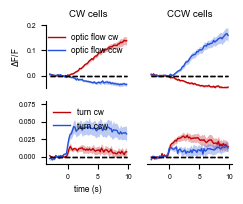

In [73]:
fig, ax = plt.subplots(2,2, figsize=(2.4, 1.8))
for i in range(2): # cell type
    for j, vm in enumerate(('optic flow','turn')): # vis or motor
        for k, sense in enumerate(('cw','ccw')): # cw or ccw
            y = mean_mean_resp[j*2+k, :, i]
            err = sem_mean_resp[j*2+k, :, i]
            ax[j, i].fill_between(t_x, y-err, y+err, color=cc.cm.CET_D1(255*(1-k)), alpha=0.3, lw=0)
            ax[j, i].plot(t_x,y, color=cc.cm.CET_D1(255*(1-k)), label=vm+' '+sense)
            ax[j, i].plot(t_x, t_x*0, 'k--')

ax[0,0].set_ylim(-0.05, 0.2)
ax[0,1].set_ylim(-0.05, 0.2)
ax[1,0].set_ylim(-0.01, 0.08)
ax[1,1].set_ylim(-0.01, 0.08)
            
toggle_spines(ax[0,0], 0,0,0,1)
toggle_spines(ax[0,1], 0,0,0,0)
toggle_spines(ax[1,0], 0,1,0,1)
toggle_spines(ax[1,1], 0,1,0,0)

ax[1,0].set_xlabel('time (s)')
ax[0,0].set_ylabel('$\Delta$F/F')

ax[0,0].set_title('CW cells')
ax[0,1].set_title('CCW cells')

ax[0,0].legend()
ax[1,0].legend()

plt.savefig('../svg/ed10_j.svg')
plt.show()